# Exploratory Data Analysis (EDA)

This notebook performs a basic EDA on the Mesa Del Sol and Liège datasets to identify data quality issues (outliers, negative values) and inform our data cleaning strategy for the `DataBuilder` classes.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.style.use('ggplot')

## 1. Mesa Del Sol Dataset

We will load all CSV files from the `../data/mesa` folder and concatenate them. We will analyze the key columns:
- `PVPCS_Active_Power` (Our PV source)
- `GE_Active_Power` (Our Load source)

In [99]:
MESA_DATA_PATH = "./mesa"
all_files = [os.path.join(MESA_DATA_PATH, f) for f in os.listdir(MESA_DATA_PATH) if f.endswith('.csv')]

df_list = []
for f in all_files:
    print(f"Loading {f}...")
    try:
        df = pd.read_csv(f, usecols=['Timestamp', 'PVPCS_Active_Power', 'GE_Active_Power', 'Island_mode_MCCB_Active_Power'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S')
        df_list.append(df)
    except Exception as e:
        print(f"Could not read {f}: {e}")

df_mesa = pd.concat(df_list).sort_values(by='Timestamp').set_index('Timestamp')
print(f"Loaded {len(df_mesa)} total 10-second intervals from Mesa Del Sol.")

Loading ./mesa\Dec_2022.csv...
Loading ./mesa\Nov_2022.csv...
Loading ./mesa\Oct_2022.csv...
Loaded 794232 total 10-second intervals from Mesa Del Sol.


In [100]:
# Get statistical summary
# This will clearly show the outliers
print("Raw Data Statistical Summary (Mesa):")
df_mesa.describe()

Raw Data Statistical Summary (Mesa):


,PVPCS_Active_Power,GE_Active_Power,Island_mode_MCCB_Active_Power
count,794232.000000,794232.000000,794232.000000
mean,-176.350588,-100.394930,-278.795106
std,13557.077643,13558.216128,13555.781616
min,-999999.000000,-999999.000000,-999999.000000
25%,0.000000,-0.200000,-126.000000
50%,0.000000,110.300003,-117.000000
75%,12.000000,117.800003,-49.000000
max,50.000000,233.500000,110.000000


### Visualize `PVPCS_Active_Power` (PV)

Let's plot the raw data. The massive outliers will make this plot unreadable, which is itself an insight.

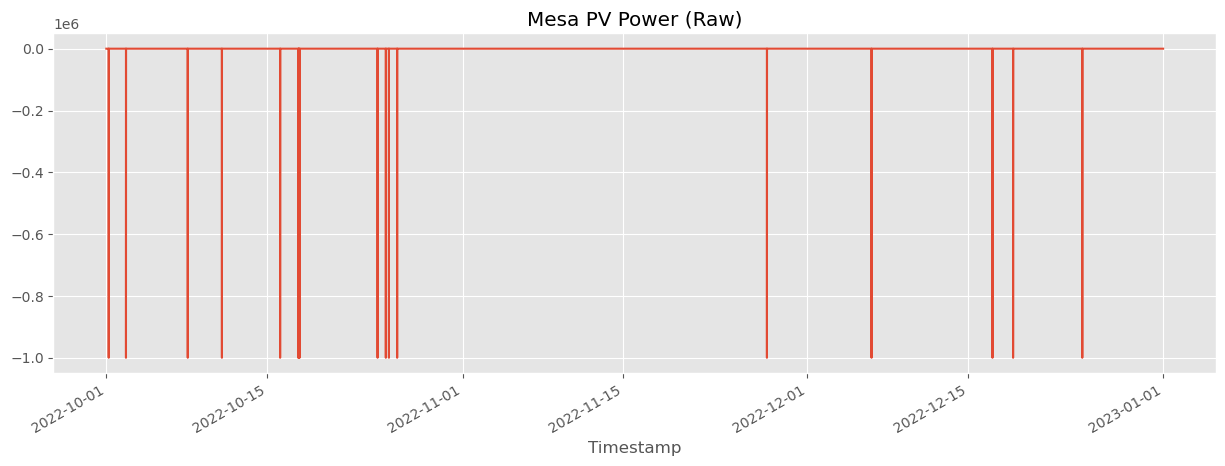

In [101]:
df_mesa['PVPCS_Active_Power'].plot(figsize=(15, 5), title='Mesa PV Power (Raw)')
plt.show()

In [104]:
min_percentile = 0.025
max_percentile = 1

sane_min_pv = df_mesa['PVPCS_Active_Power'].quantile(min_percentile) # Find 0.1th percentile
sane_max_pv = df_mesa['PVPCS_Active_Power'].quantile(max_percentile) # Find 99.9th percentile

print(f"Sane PV Min ({min_percentile*100}th percentile): {sane_min_pv:.2f} kW")
print(f"Sane PV Max ({max_percentile*100}th percentile): {sane_max_pv:.2f} kW")

# sane_min_pv = 0.0

# Create a new, cleaned DataFrame
df_mesa_cleaned = df_mesa.copy()
df_mesa_cleaned['PVPCS_Active_Power'] = df_mesa['PVPCS_Active_Power'].clip(
    lower=sane_min_pv,
    upper=sane_max_pv
)

print(f"\nPV data will be clamped to: [{sane_min_pv}, {sane_max_pv:.2f}] kW")

Sane PV Min (2.5th percentile): 0.00 kW
Sane PV Max (100th percentile): 50.00 kW

PV data will be clamped to: [0.0, 50.00] kW


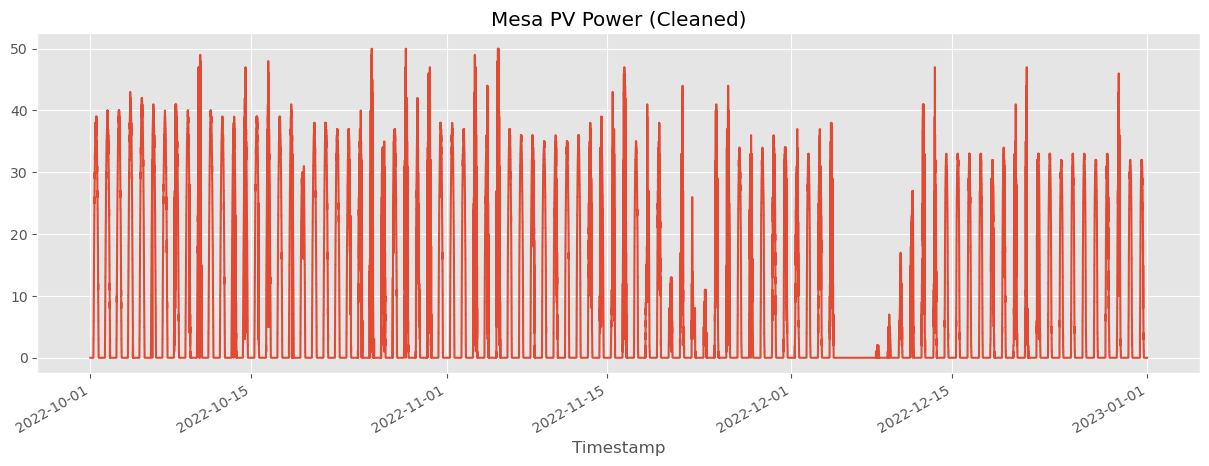

In [105]:
df_mesa_cleaned['PVPCS_Active_Power'].plot(figsize=(15, 5), title='Mesa PV Power (Cleaned)')
plt.show()

### Visualize `GE_Active_Power` (Load)

This is the total site load. Your simulation plot showed it going positive, which means the raw data must be negative.

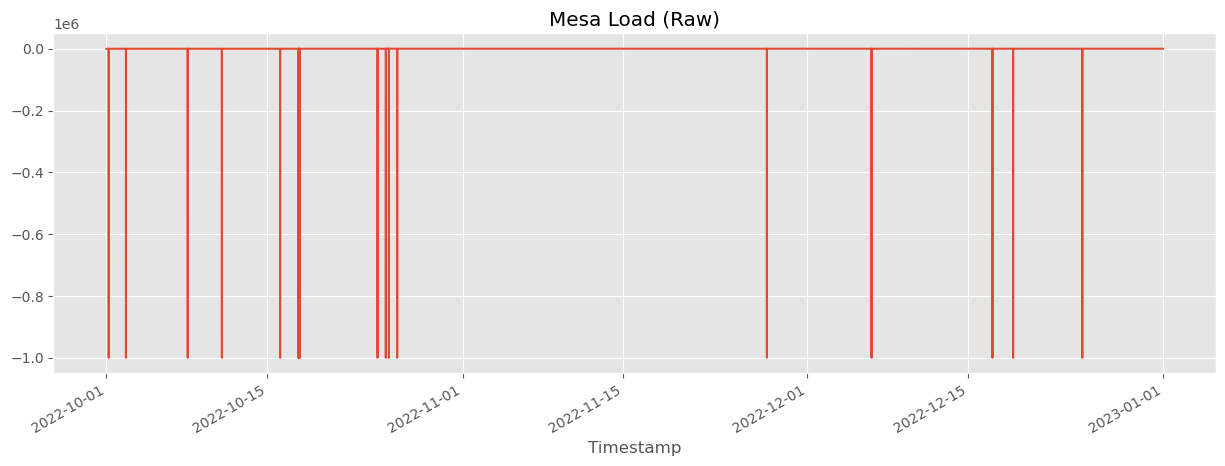

In [107]:
df_mesa['GE_Active_Power'].plot(figsize=(15, 5), title='Mesa Load (Raw)')
plt.show()

In [114]:
min_percentile = 0.0004
max_percentile = 1

sane_min_load = df_mesa['GE_Active_Power'].quantile(min_percentile) # Find 0.1th percentile
sane_max_load = df_mesa['GE_Active_Power'].quantile(max_percentile) # Find 99.9th percentile

print(f"Sane Load Min ({min_percentile*100}th percentile): {sane_min_load:.2f} kW")
print(f"Sane Load Max ({max_percentile*100}th percentile): {sane_max_load:.2f} kW")


sane_min_load = 0.0

# Add the cleaned load data to our new DataFrame
df_mesa_cleaned['GE_Active_Power'] = df_mesa['GE_Active_Power'].clip(
    lower=sane_min_load,
    upper=sane_max_load
)

print(f"\nLoad data will be clamped to: [{sane_min_load}, {sane_max_load:.2f}] kW")

Sane Load Min (0.04th percentile): -7.50 kW
Sane Load Max (100th percentile): 233.50 kW

Load data will be clamped to: [0.0, 233.50] kW


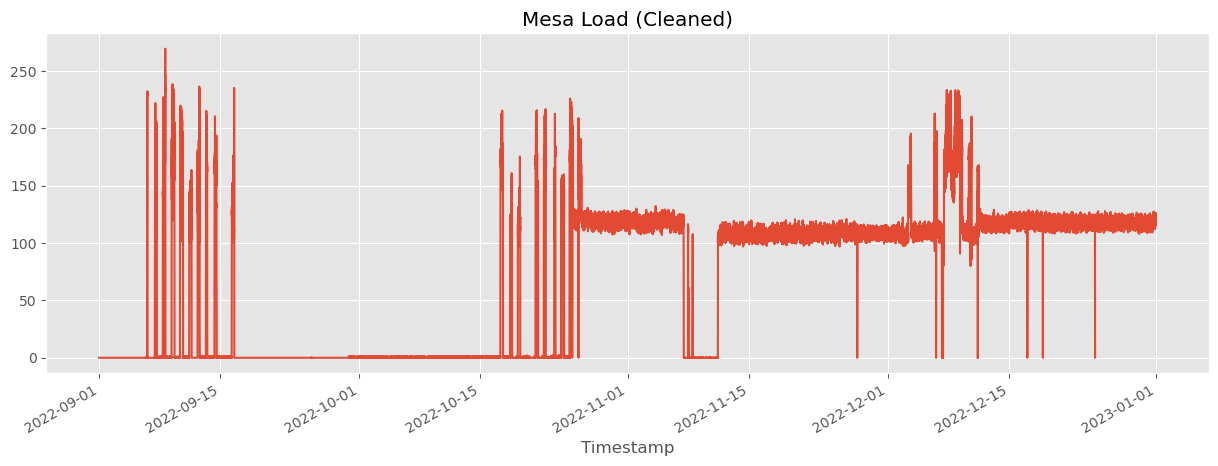

In [98]:
df_mesa_cleaned['GE_Active_Power'].plot(figsize=(15, 5), title='Mesa Load (Cleaned)')
plt.show()

### Visualize `Island_mode_MCCB_Active_Power` (Load)

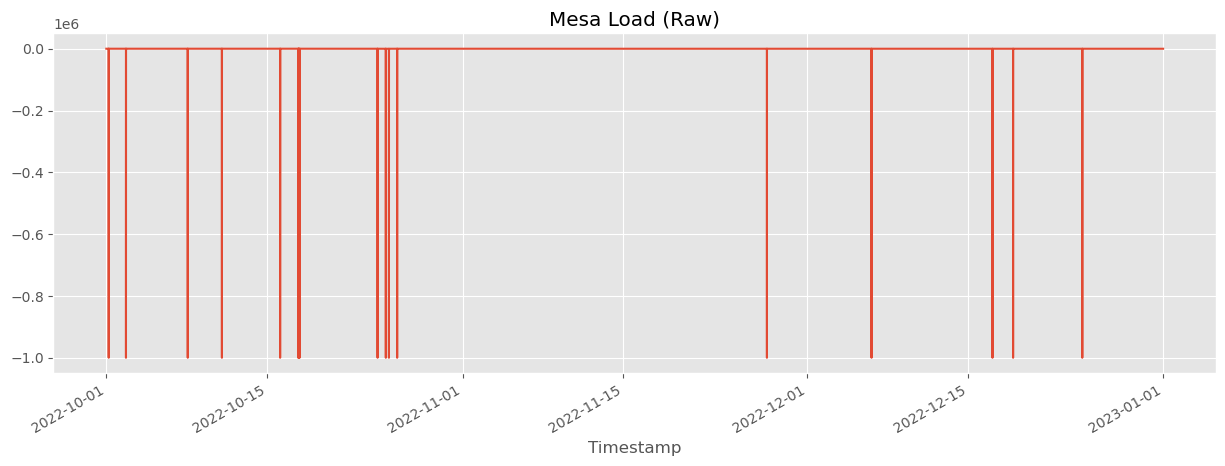

In [115]:
df_mesa['Island_mode_MCCB_Active_Power'].plot(figsize=(15, 5), title='Mesa Load (Raw)')
plt.show()

In [116]:
min_percentile = 0.0004
max_percentile = 1

sane_min_load = df_mesa['Island_mode_MCCB_Active_Power'].quantile(min_percentile) # Find 0.1th percentile
sane_max_load = df_mesa['Island_mode_MCCB_Active_Power'].quantile(max_percentile) # Find 99.9th percentile

print(f"Sane Load Min ({min_percentile*100}th percentile): {sane_min_load:.2f} kW")
print(f"Sane Load Max ({max_percentile*100}th percentile): {sane_max_load:.2f} kW")


sane_min_load = 0.0

# Add the cleaned load data to our new DataFrame
df_mesa_cleaned['Island_mode_MCCB_Active_Power'] = df_mesa['Island_mode_MCCB_Active_Power'].clip(
    lower=sane_min_load,
    upper=sane_max_load
)

print(f"\nLoad data will be clamped to: [{sane_min_load}, {sane_max_load:.2f}] kW")

Sane Load Min (0.04th percentile): -262.00 kW
Sane Load Max (100th percentile): 110.00 kW

Load data will be clamped to: [0.0, 110.00] kW


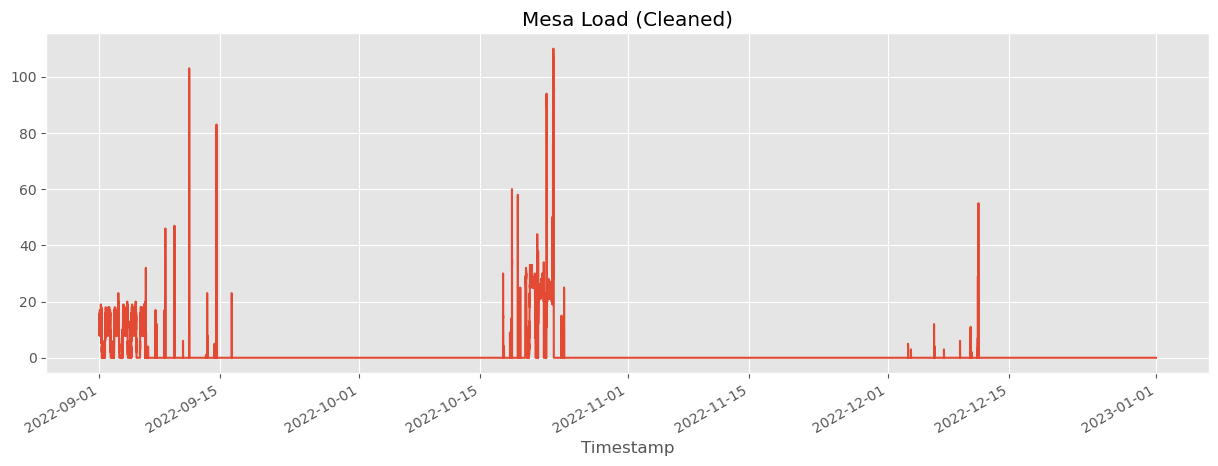

In [92]:
df_mesa_cleaned['Island_mode_MCCB_Active_Power'].plot(figsize=(15, 5), title='Mesa Load (Cleaned)')
plt.show()

### Cleaned Data Summary (Mesa)

Now that we have clamped the outliers, let's look at the statistics again.

In [88]:
print("Cleaned Data Statistical Summary (Mesa):")
df_mesa_cleaned.describe()

Cleaned Data Statistical Summary (Mesa):


,PVPCS_Active_Power,GE_Active_Power,Island_mode_MCCB_Active_Power
count,1.053216e+06,1.053216e+06,1.053216e+06
mean,8.188317e+00,5.725249e+01,-8.013977e+01
std,1.297814e+01,9.901413e+01,5.459080e+01
min,0.000000e+00,-6.002000e+02,-2.994280e+02
25%,0.000000e+00,-7.000000e-01,-1.230000e+02
50%,0.000000e+00,1.060000e+02,-1.090000e+02
75%,1.500000e+01,1.165000e+02,-2.600000e+01
max,5.100000e+01,2.695000e+02,1.100000e+02


## 2. Liège Dataset

We will load `miris_load.csv` and `miris_pv.csv`. We will ignore `weather_data.csv`.

In [11]:
LIEGE_DATA_PATH = "./liege"

df_load = pd.read_csv(os.path.join(LIEGE_DATA_PATH, "miris_load.csv"), parse_dates=['DateTime'], index_col='DateTime')
df_pv = pd.read_csv(os.path.join(LIEGE_DATA_PATH, "miris_pv.csv"), parse_dates=['DateTime'], index_col='DateTime')

# Rename columns to be clear
df_load.rename(columns={'Conso': 'Load_kW'}, inplace=True)
df_pv.rename(columns={'PV': 'PV_kW'}, inplace=True)

df_liege = pd.concat([df_load, df_pv], axis=1).dropna()
print(f"Loaded {len(df_liege)} total 5-second intervals from Liège.")

Loaded 673920 total 5-second intervals from Liège.


In [12]:
print("Raw Data Statistical Summary (Liège):")
df_liege.describe()

Raw Data Statistical Summary (Liège):


,Load_kW,PV_kW
count,673920.000000,673920.000000
mean,0.105166,0.160394
std,0.050243,0.189844
min,0.041058,0.000000
25%,0.062977,0.000000
50%,0.082932,0.065128
75%,0.153041,0.292241
max,0.264949,0.724679


### Visualize `PV_kW`

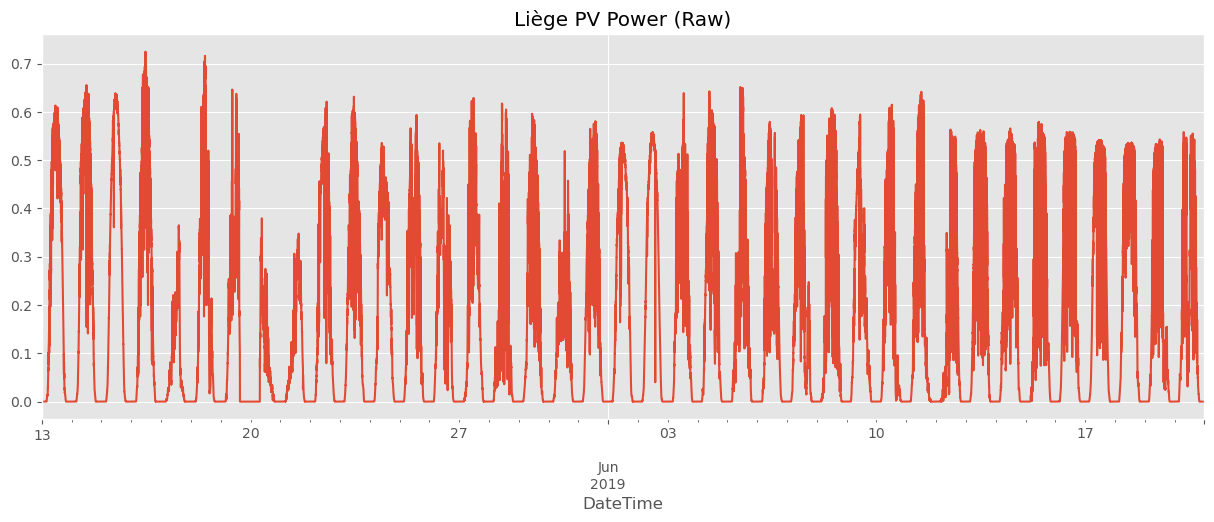

In [13]:
df_liege['PV_kW'].plot(figsize=(15, 5), title='Liège PV Power (Raw)')
plt.show()

### Visualize `Load_kW`

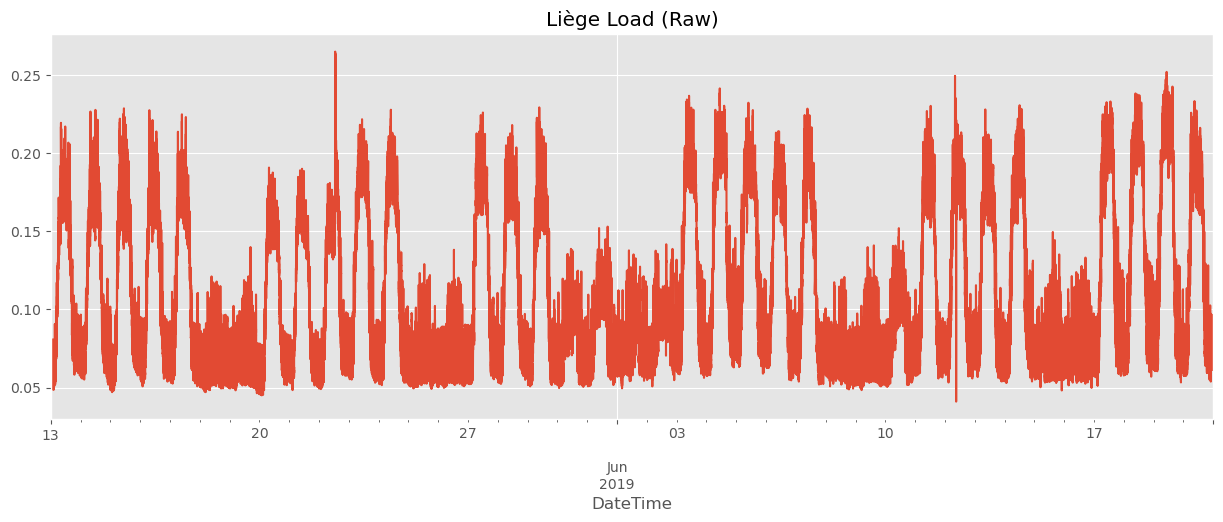

In [14]:
df_liege['Load_kW'].plot(figsize=(15, 5), title='Liège Load (Raw)')
plt.show()